<a href="https://colab.research.google.com/github/JHyunjun/torch_Reinforcement-Learning/blob/main/240505_Rentalcar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
actions = np.arange(-5,5+1) #직영점간 차량 하루 최대 유출/유입 5대

In [3]:
states = []
for i in range(20+1) :
  for j in range(20+1) :
    states.append([i,j]) #최대 주차대수 20대씩(i 직영점, j직영점)

In [4]:
value = np.zeros((20+1, 20+1)) #Value function(k)
new_value = np.zeros((20+1, 20+1)) #Value function(k+1) by Belmann Equation
new_policy = np.zeros((20+1, 20+1))
policy = np.zeros((20+1, 20+1)) #각 State에서의 Policy는 자동차가 몇대 유/출입 되었는지 표현

In [5]:
# Poisson distribution
p_dict = {}

def poisson_distribution(x,lamb) :
  global p_dict
  key = (x,lamb)
  if key not in p_dict.keys():
    p_dict[key] = lamb**x*np.exp(-lamb)/np.math.factorial(x)

  return p_dict[key]

poisson_upper_bound = 8+1 #하루 최대 8대 이상의 차가 렌트 또는 반납할 경우 거의 없음

In [6]:
def Calculate_nextV_function(state, action, state_value, gamma = 0.9) :
  returns = -2*np.abs(action) #직영점간 이동시 2점 penalty

  A_cars = int(max(min(state[0]-action, 20), 0)) #각 직영점에 있는 차량 대수의 변화
  B_cars = int(max(min(state[1]+action, 20), 0))

  for rentA in range(poisson_upper_bound) : # 1~8까지 돌면서 총 8*8*8*8번 for문 돔
    for rentB in range(poisson_upper_bound) :
      for returnA in range(poisson_upper_bound) :
        for returnB in range(poisson_upper_bound) :
          rent_prob = poisson_distribution(rentA, 3)* poisson_distribution(rentB, 4) #총 손님들이 두 직영점에 rentA,rentB만큼 대여하는 확률

          Alot_rent_fin = min(A_cars, rentA)
          Blot_rent_fin = min(B_cars, rentB)
          reward = (Alot_rent_fin + Blot_rent_fin) * 10 #두 직영점에서 대여된 차량의 대수

          return_prob = poisson_distribution(returnA,3) * poisson_distribution(returnB,2) #두 직영점에서 returnA, returnB만큼 반납하는 확률

          # 대여와 반납이 종료된 이후 각 직영점에 남아있는 차량 대수
          next_A_cars = int(max(min(A_cars - Alot_rent_fin + returnA, 20), 0))
          next_B_cars = int(max(min(B_cars - Blot_rent_fin + returnB, 20), 0))
          total_prob = rent_prob * return_prob #차량의 반납/대여는 독립사건이므로 곱연산

          returns += total_prob * (reward + gamma*state_value[next_A_cars, next_B_cars]) #최종 가치함수 V(k+1) = R + gamma*P*V(k), P;total prob, V(k);state value

  return returns

In [7]:
iter_policy = []
iter_value = []
iter_policy.append(policy) #21*21 크기의 영행렬
iter_value.append(value)

In [8]:
it = 0
while True :
  print(f' 반복 회차 : {it + 1}')
  for i,j in states :
    action_buffer = [] # 11개의 Action(-5~5)으로 나오는 가치함수를 저장할 버퍼
    for action in actions :
      if ((i >= action and action >= 0) or (action < 0 and j >= np.abs(action))) :
        # A 직영점에 현재 주차된 차가 B 직영점으로 가야할 차보다 많거나, B 직영점에 현재 주차된 차가 A 직영점으로 가야할 차보다 많을때만 Value function을 연산
        action_buffer.append(Calculate_nextV_function([i,j], action, value)) # Action_buffer는 결국 Size가 어떻게되는데?

      else :
        action_buffer.append(-np.inf)

# Greedy - algorithm -> Optimal Policy
    act_idx = np.argmax(action_buffer)
    new_policy[i,j] = actions[act_idx]

# Optimal poicy -> Optimal Value interation
    new_value[i,j] = Calculate_nextV_function([i,j], actions[act_idx], value)

  it+=1
  if np.sum(policy != new_policy) < 1e-04 : break

  value = new_value.copy()
  policy = new_policy.copy()

  iter_policy.append(policy)
  iter_value.append(value)

 반복 회차 : 1


<ipython-input-5-22bc188ebbee>:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  p_dict[key] = lamb**x*np.exp(-lamb)/np.math.factorial(x)


 반복 회차 : 2
 반복 회차 : 3
 반복 회차 : 4
 반복 회차 : 5
 반복 회차 : 6
 반복 회차 : 7
 반복 회차 : 8
 반복 회차 : 9
 반복 회차 : 10
 반복 회차 : 11
 반복 회차 : 12
 반복 회차 : 13


<ipython-input-10-3dc255231c56>:2: UserWarning: The following kwargs were not used by contour: 'level', 'colirs'
  cs = ax.contour(policy, level = 10, colirs = 'k')


Text(0.5, 1.0, 'Policy')

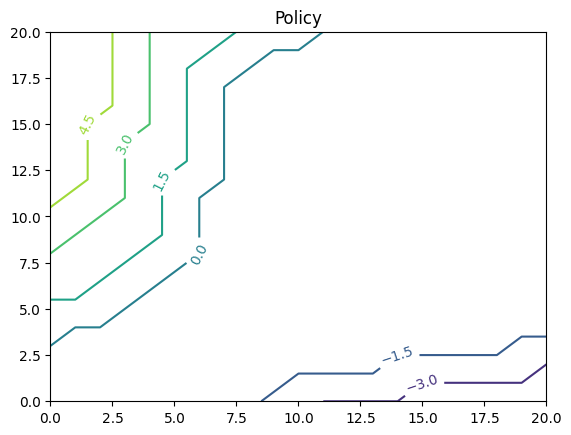

In [10]:
fig, ax = plt.subplots()
cs = ax.contour(policy, level = 10, colirs = 'k')
ax.clabel(cs, inline = 1, fontsize = 10)
ax.set_title("Policy")

<ipython-input-11-9bfd47801c88>:2: UserWarning: The following kwargs were not used by contour: 'level'
  cs = ax.contour(value, level = 10, colors = 'k')


Text(0.5, 1.0, 'Expected return')

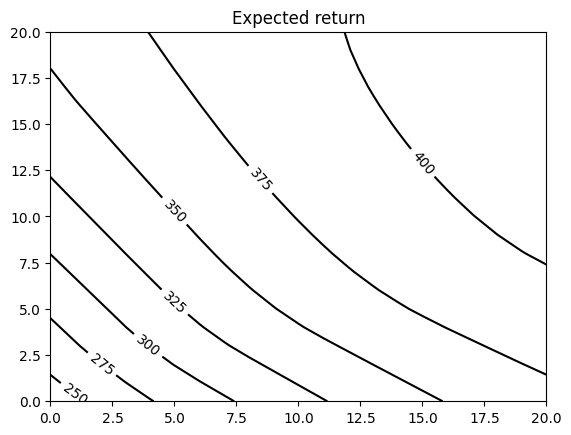

In [11]:
fig, ax = plt.subplots()
cs = ax.contour(value, level = 10, colors = 'k')
ax.clabel(cs, inline = 1, fontsize = 10)
ax.set_title("Expected return")